In [9]:
library(tidyverse)
library(plyranges)
library(rtracklayer)
library(GenomicRanges)
library(karyoploteR)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ dplyr::between()      masks plyranges::between()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks BiocGenerics::combine()
✖ dplyr::desc()         masks IRanges::desc()
✖ tidyr::expand()       masks S4Vectors::expand()
✖ dplyr::filter()       masks plyranges::filter(), stats::filter()
✖ dplyr::first()        masks S4Vectors::firs

In [10]:
# Import exon coordinates from BED file
exons <- import("../../FunctionalElements/Ucsc/GRCh38_refseq.bed", format = "BED")
exons_autosomes = keepStandardChromosomes(exons, pruning.mode="coarse")

In [11]:
# Load chromosome sizes file (format: "chr1 <size>")
chrom_sizes <- read.table("../../FunctionalElements/Ucsc/hg38.chrom.sizes", col.names = c("seqnames", "size"), stringsAsFactors = FALSE)

# Convert to a GRanges object
chrom_granges <- GRanges(seqnames = chrom_sizes$seqnames, ranges = IRanges(start = 1, end = chrom_sizes$size))
chrom_granges_auto = keepStandardChromosomes(chrom_granges, pruning.mode="coarse")
# Create 1Mb genome windows
windows <- as_granges(chrom_granges_auto) %>%
           tile_ranges(width = 1e6)  # 1Mb windows

In [16]:
gr_exon_density <- windows %>%
  mutate(exon_count = count_overlaps(., exons_autosomes))

In [17]:
gr_exon_density

GRanges object with 3103 ranges and 2 metadata columns:
         seqnames            ranges strand | partition exon_count
            <Rle>         <IRanges>  <Rle> | <integer>  <integer>
     [1]     chr1          1-999824      * |         1        229
     [2]     chr1    999825-1999649      * |         1       1954
     [3]     chr1   1999650-2999474      * |         1        644
     [4]     chr1   2999475-3999299      * |         1        807
     [5]     chr1   3999300-4999124      * |         1         10
     ...      ...               ...    ... .       ...        ...
  [3099]    chr21 42734666-43728494      * |        24        388
  [3100]    chr21 43728495-44722324      * |        24        560
  [3101]    chr21 44722325-45716153      * |        24        542
  [3102]    chr21 45716154-46709983      * |        24       1052
  [3103]     chrM           1-16569      * |        25         13
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [19]:
exon_density = gr_exon_density %>% as_tibble()

In [49]:
exon_density = exon_density %>% mutate(dens=exon_count/1000000*300)

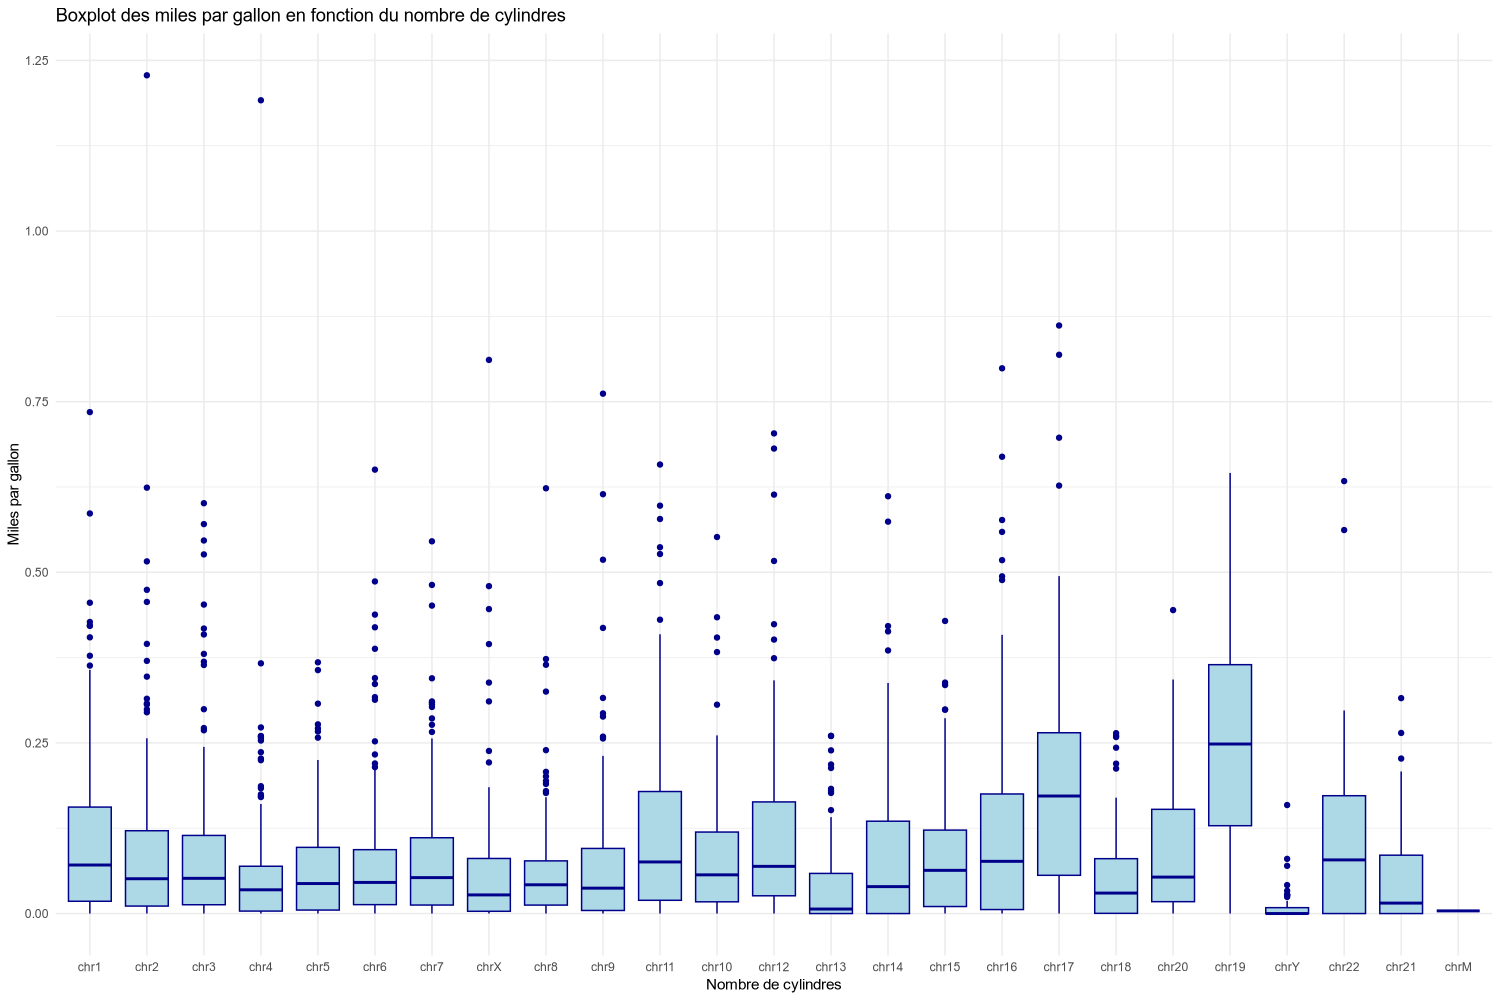

In [54]:
options(repr.plot.width = 15, repr.plot.height =10, repr.plot.res = 100)
exon_density %>% ggplot(aes(x = seqnames, y = dens)) +
  geom_boxplot(fill = "lightblue", color = "darkblue") +
  labs(title = "Boxplot des miles par gallon en fonction du nombre de cylindres",
       x = "Nombre de cylindres",
       y = "Miles par gallon") +
  theme_minimal()

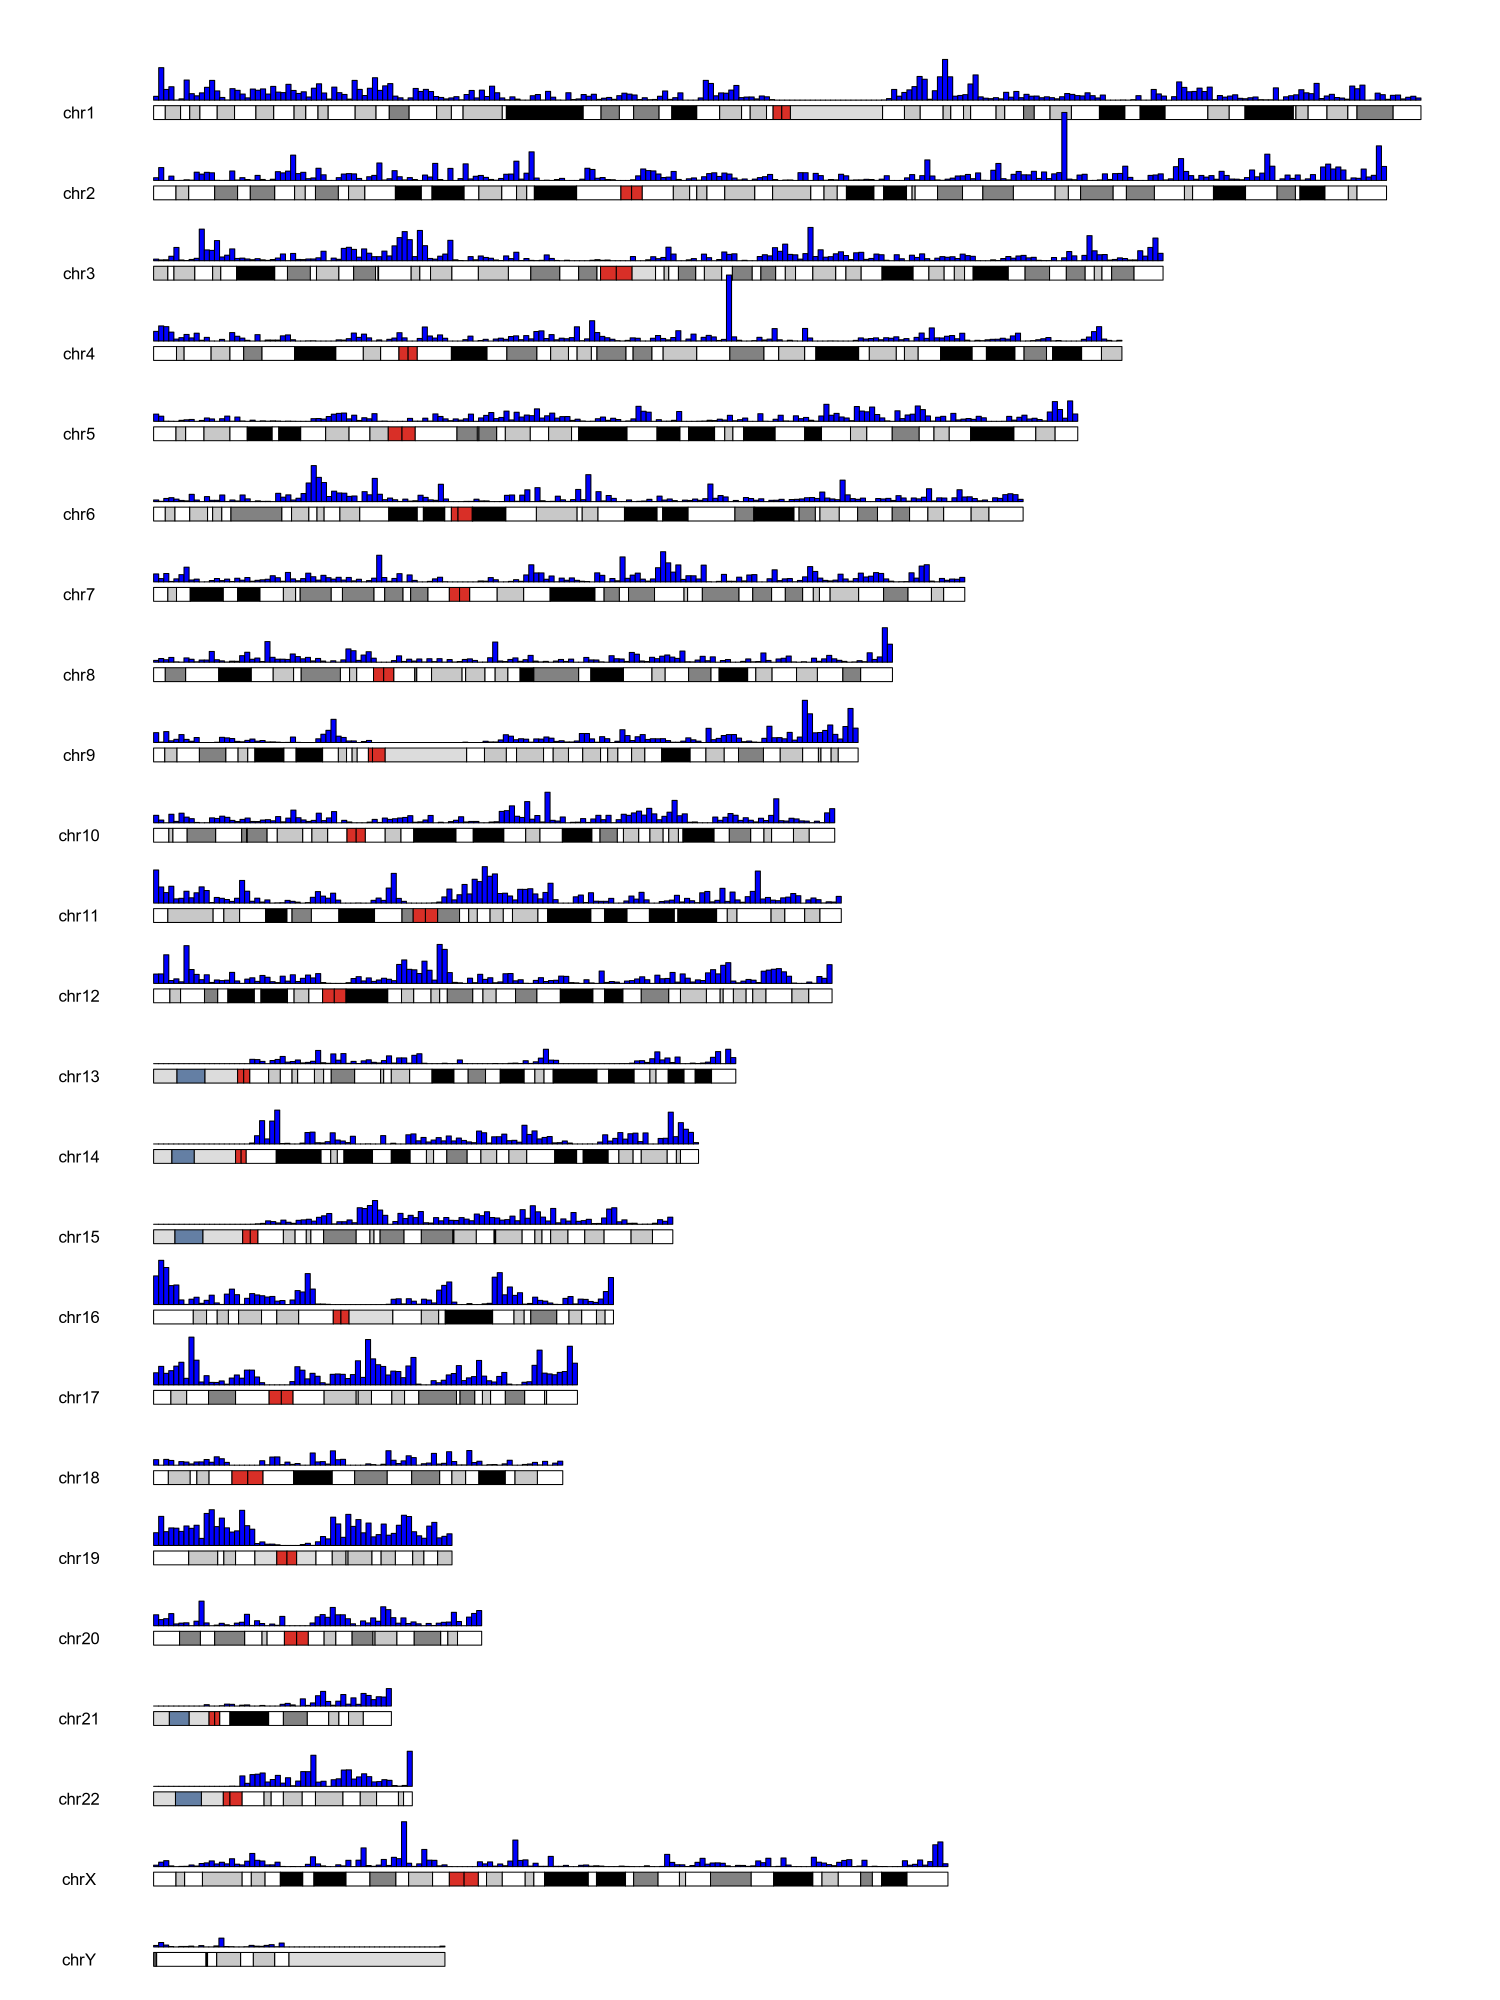

In [50]:
options(repr.plot.width = 15, repr.plot.height =20, repr.plot.res = 100)
kp <- plotKaryotype(genome="hg38", plot.type="1")  # Change genome if needed
kpBars(kp, chr=exon_density$seqnames, x0=exon_density$start, x1=exon_density$end, 
       y1=exon_density$dens, col="blue", border="black")